In [1]:
!unset LD_PRELOAD

In [2]:
import warnings
warnings.simplefilter("ignore")
import os
import sys
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import time
import logging
tf.get_logger().setLevel(logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift, fftn
import matplotlib.pyplot as plt

# tf.debugging.set_log_device_placement(True)

from utils_gpu import NeuralNet, create_ds, poisson

2025-04-11 18:00:58.164937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-11 18:00:58.321484: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 18:00:59.135340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/apps/extern/python/envs/jupyterlab/3.4.5/lib:/home/akavuturu/.conda/envs/msnn-env/lib:/data/apps/linux-centos8-cascadelake/gcc-9.3.0/openmpi-3.1.6-rk3nyoehbq3pke4zy4hn7unns3ujtutx/lib:/d

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
class MultistageNeuralNetwork:
    """
    MultistageNeuralNetwork is a multi-stage model used for predicting
    high-dimensional function outputs through regression. This class encapsulates
    the functionality for constructing, training, and predicting using a sequence
    of neural networks, where each stage of the network can focus on different
    aspects of the data.

    Attributes:
        dim (int): Dimensionality of the input data.
        N (int): Number of points per dimension in the dataset.
        stages (list): List of neural networks, one for each stage.
        layers (list): Architecture of the neural network (input layer, hidden layers, output layer).
        lt (list): Minimum values for each dimension in the input data.
        ut (list): Maximum values for each dimension in the input data.
    """

    def __init__(self, x_train, num_hidden_layers, num_hidden_nodes):
        """
        Initialize the MultistageNeuralNetwork instance.

        Args:
            x_train (tf.Tensor): Input training data.
            num_stages (int): Number of stages in the multi-stage neural network.
            num_hidden_layers (int): Number of hidden layers in each stage.
            num_hidden_nodes (int): Number of nodes in each hidden layer.
        """
        self.dim = x_train.shape[-1]                                 # Number of dimensions in the input data.
        self.N = int(round(x_train.shape[0] ** (1 / self.dim)))      # Number of points per dimension.
        # self.stages = [None] * num_stages                            # List to store each stage's neural network.
        self.stages = []
        self.layers = [self.dim] + ([num_hidden_nodes] * num_hidden_layers) + [1]  # Neural network architecture.
        self.lt = [tf.math.reduce_min(x_train[:, i]) for i in range(x_train.shape[-1])]  # Min values for each dimension.
        self.ut = [tf.math.reduce_max(x_train[:, i]) for i in range(x_train.shape[-1])]  # Max values for each dimension.

    def train(self, x_train, y_train, stage, kappa, iters):
        """
        Train a specific stage of the neural network.

        Args:
            x_train (tf.Tensor): Input training data.
            y_train (tf.Tensor): Corresponding labels for training.
            stage (int): The stage index to train.
            kappa (float): Scaling factor for activation.
            iters (list): Number of iterations for [Adam optimizer, L-BFGS optimizer].
        """
        act = 0 if stage == 0 else 1  # Use different activation for first stage.
        lt = [tf.cast(tf.math.reduce_min(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]
        ut = [tf.cast(tf.math.reduce_max(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]

        self.stages.append(NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act))
        # self.stages[stage] = NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act)
        self.stages[stage].train(iters[0], 1)  # Train using Adam optimizer.
        self.stages[stage].train(iters[1], 2)  # Train using L-BFGS optimizer.

    @staticmethod
    def fftn_(x_train, residue):
        """
        Perform a Fast Fourier Transform (FFT) to analyze the frequency domain of the residue.

        Args:
            x_train (tf.Tensor): Input training data.
            residue (tf.Tensor): Residual errors between predictions and true values.

        Returns:
            float: Adjusted scaling factor (kappa) based on the dominant frequency.
        """
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1 / dim)))
        g = residue.numpy()

        GG = g.reshape([N_train] * dim)  # Reshape residue into a grid.
        G = fftn(GG)                    # Perform FFT.
        G_shifted = fftshift(G)         # Shift zero-frequency component to the center.

        N = len(G)
        total_time_range = 2  # Time range from -1 to 1.
        sample_rate = N / total_time_range  # Sampling rate.

        half_N = N // 2
        T = 1.0 / sample_rate
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]  # Extract positive frequencies.

        freqs = [fftshift(fftfreq(GG.shape[i], d=T)) for i in range(len(GG.shape))]
        freq_pos = [freqs[i][half_N:] for i in range(len(freqs))]

        magnitude_spectrum = np.abs(G_pos)
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(len(freq_pos))]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim)  # Normalize magnitude.

        dominant_freq = max(dominant_freqs)
        # print(f"Sample rate = {sample_rate} Hz, Dominant Frequency = {dominant_freq} Hz, Magnitude = {magnitude}")

        kappa_f = 2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi * 0.01
        # print(f"New Kappa: {kappa_f}")
        return kappa_f, dominant_freq
    
    def sfftn(x_train, residue, sparsity_threshold=0.01, k=None):
        """
        Perform a Sparse Fast Fourier Transform (SFFT) to analyze the frequency domain of the residue,
        optimized for high-dimensional data. Assumes data is already on a complete grid.

        Args:
            x_train (tf.Tensor): Input training data with coordinates.
            residue (tf.Tensor): Residual errors between predictions and true values.
            sparsity_threshold (float): Threshold below which frequency components are set to zero (relative to max).
            max_frequencies (int, optional): Maximum number of frequency components to keep. If None, use threshold only.

        Returns:
            tuple: (kappa_f, dominant_freq, sparse_spectrum)
                - kappa_f: Adjusted scaling factor based on the dominant frequency
                - dominant_freq: The dominant frequency identified
                - sparse_spectrum: Sparse representation of the frequency spectrum
        """
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1 / dim)))
        g = residue.numpy().flatten()
        
        grid = g.reshape([N_train] * dim)

        # For very high dimensions, we may need to use a smaller grid
        downsample_factor = 1
        if dim > 4:
            downsample_factor = max(1, N_train // 16)

        slices = tuple(slice(None, None, downsample_factor) for _ in range(dim))
        GG = grid[slices]
        G = fftn(GG)
        G_shifted = fftshift(G)
        
        N = GG.shape[0]
        total_time_range = 2  # Time range from -1 to 1
        sample_rate = N / total_time_range
        half_N = N // 2
        T = 1.0 / sample_rate
        
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]
        
        freqs = [fftshift(fftfreq(N, d=T)) for _ in range(dim)]
        freq_pos = [freqs[i][half_N:] for i in range(dim)]

        magnitude_spectrum = np.abs(G_pos)
        max_magnitude = np.max(magnitude_spectrum)

        if sparsity_threshold > 0:
            mask = magnitude_spectrum > (sparsity_threshold * max_magnitude)
            if k is not None and np.sum(mask) > k:
                flat_idx = np.argsort(magnitude_spectrum.flatten())[::-1][:k]
                new_mask = np.zeros_like(magnitude_spectrum, dtype=bool).flatten()
                new_mask[flat_idx] = True
                mask = new_mask.reshape(magnitude_spectrum.shape)
        else:
            mask = np.ones_like(magnitude_spectrum, dtype=bool)
        
        sparse_magnitude = np.zeros_like(magnitude_spectrum)
        sparse_magnitude[mask] = magnitude_spectrum[mask]
        
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(dim)]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim)
        
        dominant_freq = max(dominant_freqs)
        kappa_f = 2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi * 0.01
        
        if dim <= 2:
            sparse_spectrum = sparse_magnitude
        else:
            sparse_idx = np.where(mask)
            values = magnitude_spectrum[sparse_idx]
            sparse_spectrum = (sparse_idx, values, magnitude_spectrum.shape)
        
        return kappa_f, dominant_freq, sparse_spectrum

    def find_zeros(residue):
        sign_residue = np.sign(residue)
        num_zeros = 0
        for axis in range(residue.ndim):
            shifted_signs = np.roll(sign_residue, shift=-1, axis=axis)
            mask = (sign_residue[:-1] * shifted_signs[:-1]) < 0
            num_zeros += np.count_nonzero(mask)
        kappa = 3 * num_zeros
        return kappa

In [24]:
dim = 1
L = 2.04
num_stages = 4
num_hidden_layers = 3
num_hidden_nodes = 20
precision = 1e-8
points_per_dim = 5000

N_train = points_per_dim ** dim
x_train = create_ds(dim, -L/2, L/2, N_train)
y_train = tf.reshape(poisson(x_train), [len(x_train), 1])
training_iters = list([(3000, 6000)] + [(5000, 8000*i) for i in range(2, 15)])[:num_stages]

print(x_train.shape, y_train.shape)

(5000, 1) (5000, 1)


In [29]:
# STAGE 1
MSNN_SFFT = MultistageNeuralNetwork(x_train, num_hidden_layers, num_hidden_nodes)
# MSNN_FFT = MultistageNeuralNetwork(x_train, num_hidden_layers, num_hidden_nodes)
kappa = 1
print(f"TRAINING STAGE {1}: Data size: {x_train.shape}")
MSNN_SFFT.train(x_train, y_train, stage=0, kappa=1, iters=training_iters[0])
curr_residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(1)])
mean_residue = tf.reduce_mean(tf.abs(curr_residue_sfft))
print(f"Completed training stage 1, loss={MSNN_SFFT.stages[-1].loss[-1]}, residue={mean_residue}")

TRAINING STAGE 1: Data size: (5000, 1)


LBFGS Optimization:  21%|██        | 1254/6000 [00:28<01:47, 44.30iter/s]

Completed training stage 1, loss=3.02591887457313e-07, residue=0.000478288497458896


In [30]:
i = 1
while i < num_stages:
    # kappa_f, _ = MultistageNeuralNetwork.fftn_(x_train, curr_residue_fft)
    kappa_s, _, _ = MultistageNeuralNetwork.sfftn(x_train, curr_residue_sfft)
    print(f"TRAINING STAGE {i + 1}")

    curr_residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(i)])
    mean_residue = tf.reduce_mean(tf.abs(curr_residue_sfft))
    MSNN_SFFT.train(x_train, curr_residue_sfft, stage=i, kappa=kappa_s, iters=training_iters[i])
    print(f"Completed training stage {i + 1} SFFT, loss={MSNN_SFFT.stages[-1].loss[-1]}, residue={mean_residue}")
    i += 1

if i >= num_stages:
        print(f"Reached maximum stages, loss={MSNN_SFFT.stages[-1].loss[-1]}, residue={mean_residue}")
else:
    print(f"Exited training unexpectedly, previous loss={MSNN_SFFT.stages[-2].loss[-1]}, previous residue={mean_residue}")

TRAINING STAGE 2


LBFGS Optimization:  19%|█▊        | 2996/16000 [01:02<04:25, 49.00iter/s]


Mode: LBFGSIter: 3000, loss: 7.0219e-13


LBFGS Optimization:  37%|███▋      | 5999/16000 [02:05<03:29, 47.65iter/s]


Mode: LBFGSIter: 6000, loss: 1.5357e-13


LBFGS Optimization:  56%|█████▌    | 8999/16000 [03:07<02:24, 48.43iter/s]


Mode: LBFGSIter: 9000, loss: 8.8366e-14


LBFGS Optimization:  75%|███████▍  | 11997/16000 [04:10<01:22, 48.45iter/s]


Mode: LBFGSIter: 12000, loss: 6.1080e-14


LBFGS Optimization:  94%|█████████▎| 14997/16000 [05:12<00:21, 46.13iter/s]


Mode: LBFGSIter: 15000, loss: 4.5942e-14


LBFGS Optimization:  98%|█████████▊| 15702/16000 [05:27<00:06, 47.95iter/s]


Completed training stage 2 SFFT, loss=4.438170455376206e-14, residue=0.000478288497458896
TRAINING STAGE 3


LBFGS Optimization:  12%|█▏        | 2995/24000 [01:04<07:20, 47.71iter/s]


Mode: LBFGSIter: 3000, loss: 1.2073e-14


LBFGS Optimization:  25%|██▍       | 5999/24000 [02:07<06:27, 46.46iter/s]


Mode: LBFGSIter: 6000, loss: 4.4164e-15


LBFGS Optimization:  37%|███▋      | 8995/24000 [03:09<05:13, 47.92iter/s]


Mode: LBFGSIter: 9000, loss: 3.0326e-15


LBFGS Optimization:  50%|████▉     | 11999/24000 [04:12<03:56, 50.72iter/s]


Mode: LBFGSIter: 12000, loss: 5.9044e-16


LBFGS Optimization:  62%|██████▏   | 14999/24000 [05:11<02:52, 52.27iter/s]


Mode: LBFGSIter: 15000, loss: 1.4555e-16


LBFGS Optimization:  75%|███████▍  | 17998/24000 [06:10<01:56, 51.52iter/s]


Mode: LBFGSIter: 18000, loss: 8.2694e-17


LBFGS Optimization:  87%|████████▋ | 20997/24000 [07:09<00:58, 51.30iter/s]


Mode: LBFGSIter: 21000, loss: 6.6774e-17


LBFGS Optimization:  98%|█████████▊| 23587/24000 [08:00<00:08, 49.11iter/s]


Completed training stage 3 SFFT, loss=6.097971820704114e-17, residue=1.4868842097967725e-07
TRAINING STAGE 4


LBFGS Optimization:   9%|▉         | 2995/32000 [00:59<09:28, 50.99iter/s]


Mode: LBFGSIter: 3000, loss: 1.4062e-18


LBFGS Optimization:  19%|█▊        | 5994/32000 [01:58<08:28, 51.12iter/s]


Mode: LBFGSIter: 6000, loss: 4.4016e-19


LBFGS Optimization:  28%|██▊       | 8994/32000 [02:57<07:31, 51.00iter/s]


Mode: LBFGSIter: 9000, loss: 2.2291e-19


LBFGS Optimization:  37%|███▋      | 11995/32000 [03:56<06:32, 50.94iter/s]


Mode: LBFGSIter: 12000, loss: 1.3403e-19


LBFGS Optimization:  47%|████▋     | 14994/32000 [04:55<05:39, 50.08iter/s]


Mode: LBFGSIter: 15000, loss: 9.3017e-20


LBFGS Optimization:  56%|█████▌    | 17998/32000 [05:54<04:29, 51.89iter/s]


Mode: LBFGSIter: 18000, loss: 6.9382e-20


LBFGS Optimization:  66%|██████▌   | 20997/32000 [06:53<03:35, 51.17iter/s]


Mode: LBFGSIter: 21000, loss: 5.2783e-20


LBFGS Optimization:  75%|███████▍  | 23996/32000 [07:51<02:36, 51.03iter/s]


Mode: LBFGSIter: 24000, loss: 4.1831e-20


LBFGS Optimization:  84%|████████▍ | 26996/32000 [08:50<01:38, 50.70iter/s]


Mode: LBFGSIter: 27000, loss: 3.4960e-20


LBFGS Optimization:  94%|█████████▎| 29995/32000 [09:49<00:39, 51.07iter/s]


Mode: LBFGSIter: 30000, loss: 3.0498e-20


LBFGS Optimization: 100%|█████████▉| 31866/32000 [10:26<00:02, 50.86iter/s]

Completed training stage 4 SFFT, loss=2.8007038692618495e-20, residue=5.781055270255423e-09
Reached maximum stages, loss=2.8007038692618495e-20, residue=5.781055270255423e-09


In [32]:
import pickle
def save_model(model, file_path):
    model_data = {
        'dim': model.dim,
        'N': model.N,
        'layers': model.layers,
        'lt': [lt.numpy() for lt in model.lt],
        'ut': [ut.numpy() for ut in model.ut],
        'stages': []
    }

    for stage in model.stages:
        stage_data = {
            'weights': [w.numpy() for w in stage.weights],
            'biases': [b.numpy() for b in stage.biases],
            'lt': stage.lt,
            'ut': stage.ut,
            'kappa': stage.kappa,
            'acts': stage.actv,
            'loss': stage.loss
        }
        model_data['stages'].append(stage_data)

    with open(file_path, 'wb') as f:
        pickle.dump(model_data, f)
        
save_model(MSNN_SFFT, "models/model_dim1.pkl")

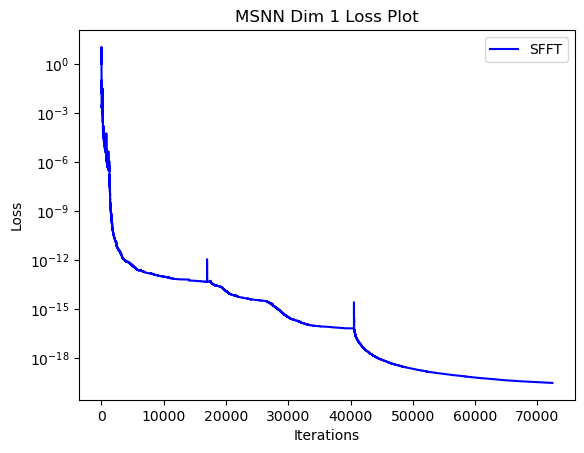

In [33]:
loss_s = np.concatenate([stage.loss for stage in MSNN_SFFT.stages])
# loss_f = np.concatenate([stage.loss for stage in MSNN_FFT.stages])
plt.figure()
plt.plot(loss_s, 'b-', label='SFFT')
# plt.plot(loss_f, 'r', label='FFT')
plt.yscale("log")
plt.title(f"MSNN Dim {dim} Loss Plot")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

plt.savefig('plots/1d_loss_curve.png')

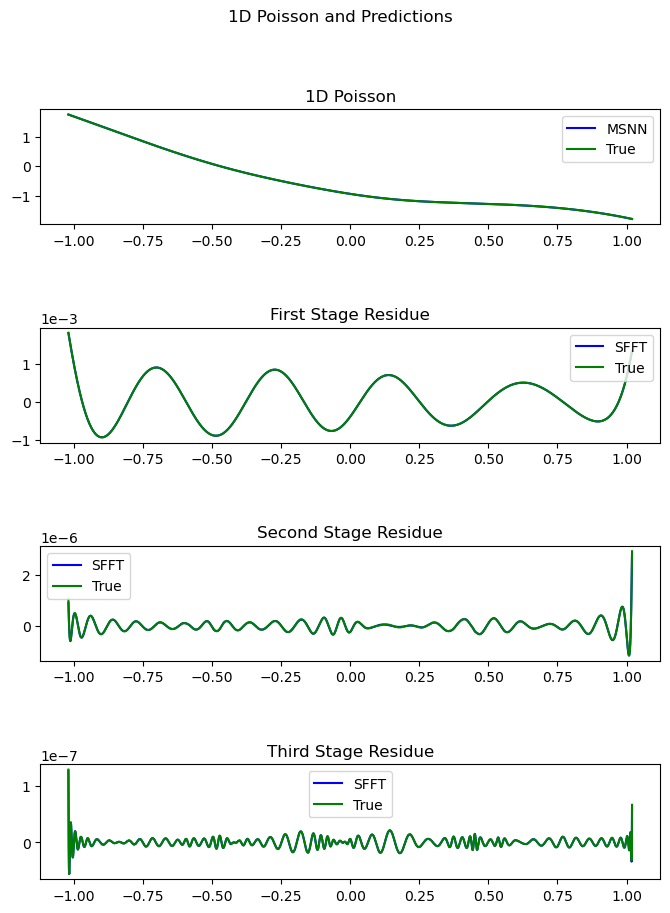

In [35]:
yhat_1_sfft = MSNN_SFFT.stages[0].predict(x_train)
# yhat_1_fft = MSNN_FFT.stages[0].predict(x_train)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8, 10))
fig.subplots_adjust(hspace=0.9)
plt.suptitle("1D Poisson and Predictions")

ax1.set_title("1D Poisson")
ax1.plot(x_train, yhat_1_sfft, 'b', label='MSNN')
ax1.plot(x_train, y_train, 'g', label='True')
ax1.legend()

# plt.savefig("plots/1d_first_stage_pred")

residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(1)])
yhat_2_sfft = MSNN_SFFT.stages[1].predict(x_train)

ax2.set_title("First Stage Residue")
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.plot(x_train, yhat_2_sfft, 'b', label='SFFT')
ax2.plot(x_train, residue_sfft, 'g', label='True')
ax2.legend()

# plt.savefig("plots/1d_second_stage_pred")

residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(2)])
yhat_3_sfft = MSNN_SFFT.stages[2].predict(x_train)

ax3.set_title("Second Stage Residue")
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.plot(x_train, yhat_3_sfft, 'b', label='SFFT')
ax3.plot(x_train, residue_sfft, 'g', label='True')
ax3.legend()

residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(3)])
yhat_4_sfft = MSNN_SFFT.stages[3].predict(x_train)

ax4.set_title("Third Stage Residue")
ax4.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax4.plot(x_train, yhat_4_sfft, 'b', label='SFFT')
ax4.plot(x_train, residue_sfft, 'g', label='True')
ax4.legend()

fig.show()
plt.savefig("plots/1d_combined_predictions")

In [36]:
def analytical_solution(x):
    """
    Analytical solution to the d-dimensional Poisson equation:
    u(x) = prod(sin(pi*x_i))
    """
    return tf.reduce_prod(tf.math.sin(np.pi * x), axis=1)

def compute_error(model, x_test, exact_solution):
    """
    Compute relative L2 and L-infinity errors.
    """
    y_pred = predict(model, x_test)
    y_true = exact_solution(x_test)
    y_true = tf.reshape(y_true, y_pred.shape)
    
    abs_error = tf.abs(y_pred - y_true)
    l2_error = tf.sqrt(tf.reduce_mean(tf.square(abs_error))) / tf.sqrt(tf.reduce_mean(tf.square(y_true)))
    linf_error = tf.reduce_max(abs_error) / tf.reduce_max(tf.abs(y_true))
    
    return l2_error.numpy(), linf_error.numpy()

In [37]:
def predict(model, x_train):
    pred = tf.add_n([model.stages[j].predict(x_train) for j in range(len(model.stages))])
    return pred

In [38]:
def generate_1d_reproduction_data():
    """
    Reproduce the 1D results from Wang and Lai (2024).
    """
    logging.info("Generating 1D reproduction data")
    dim = 1
    points_per_dim = 50  # Higher resolution for 1D
    num_stages = 5
    
    # Generate data for convergence plot (Figure 1)
    x_test = create_ds(dim, -1.0, 1.0, 200)
    stage_errors = []
    
    # Calculate error after each stage
    for s in range(1, len(MSNN_SFFT.stages) + 1):
        partial_msnn = MultistageNeuralNetwork(x_test, 3, 20)
        partial_msnn.stages = MSNN_SFFT.stages[:s]
        l2_error, linf_error = compute_error(partial_msnn, x_test, analytical_solution)
        stage_errors.append((s, l2_error, linf_error))
    
    # Create convergence plot
    plt.figure(figsize=(10, 6))
    stages, l2_errors, _ = zip(*stage_errors)
    plt.semilogy(stages, l2_errors, 'o-', linewidth=2, markersize=8)
    plt.grid(True, which="both", ls="--")
    plt.xlabel('Stage', fontsize=14)
    plt.ylabel('Relative $L^2$ Error', fontsize=14)
    plt.title('Convergence of MSNN for 1D Poisson Equation', fontsize=16)
    plt.savefig('plots/figure1_1d_convergence.png', dpi=300, bbox_inches='tight')
    
    print(f"1D reproduction complete: final L2 error = {l2_errors[-1]:.6e}")
    return stage_errors

1D reproduction complete: final L2 error = 2.283428e+00


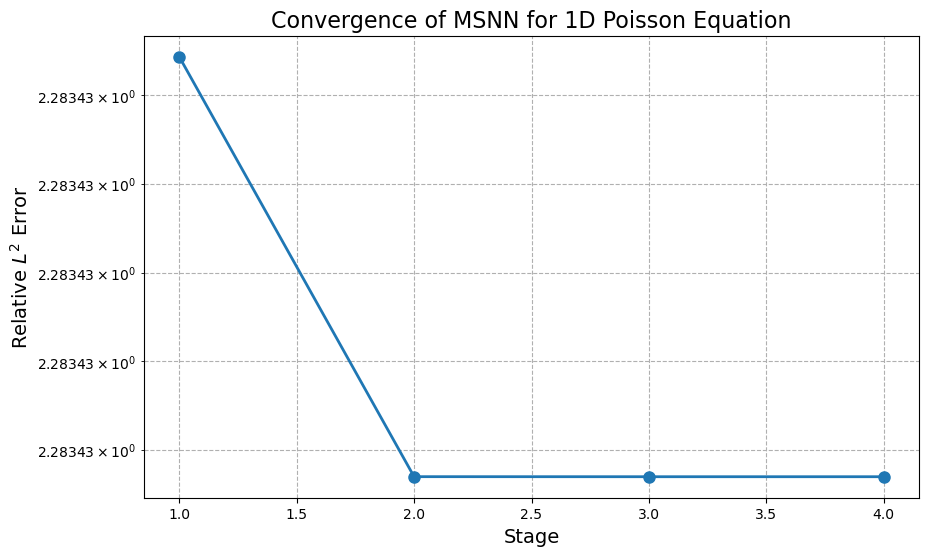

In [39]:
stage_errors = generate_1d_reproduction_data()